In [1]:
from squlearn.feature_map.qcnn_feature_map import qcnn_feature_map
from squlearn.feature_map.qcnn_feature_map import prototype_routine
import dill as pickle
from squlearn.util import Executor
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
import numpy as np
import itertools
import random
from squlearn.expectation_operator import SingleProbability
from squlearn.qnn import QNN
from squlearn.feature_map.layered_feature_map import LayeredFeatureMap
from qiskit.primitives import Estimator
from squlearn.qnn.training import regression
from squlearn.optimizers import SLSQP,Adam
from squlearn.qnn.loss import SquaredLoss
from squlearn.qnn.qnnc import QNNClassifier

In [2]:
def generate_data_all_combi(length):
    """Creates a 2 dimensional numpy array with all combinations of zeros and ones.
      It outputs this with there labels (0 if more zeros than ones, 1 else)"""
    all_combi_list = list(itertools.product([0,1],repeat=length))
    X_tuple_list = all_combi_list
    X = np.array(X_tuple_list)  #converts list of tuples into a numpy array with dimension 2
    Y = np.count_nonzero(X==0,axis=1) #counts the number of zeros in each sublist
    for i in range(len(Y)):
        zeros = Y[i]
        if 2*zeros > length:
            Y[i] = 0
        else:
            Y[i] = 1
    return X,Y

def generate_train_data(all_combination_data,train_size):
    """Generates from given all_combination data a train set with there labels."""
    X,Y = all_combination_data[0],all_combination_data[1]
    data_size = Y.size
    index_list = range(data_size)
    random.seed(1)
    index_choice = random.sample(index_list, train_size)
    X_train = np.array([X[i] for i in index_choice])
    Y_train = np.array([Y[i] for i in index_choice])
    return X_train,Y_train

In [3]:

qubits = 5
train_set_size = 20
#-------------------------------------------------------------------------------------------------------------------------------------------
#QCNN feature map with no controlled rotation in convolution layer but with cx for entangling, in fully connected: every qubit rotates differently
qcnn_train = qcnn_feature_map(qubits)

x = ParameterVector("x",6)
conv_gate1 = QuantumCircuit(2)
conv_gate1.rx(x[0],0)
conv_gate1.cx(0,1)
conv_gate1.rx(x[1],1)
conv_gate1.cx(1,0)
conv_gate1.ry(x[2],0)

pool_gate = QuantumCircuit(2)
pool_gate.cy(1,0)

f = ParameterVector("f",6)
fully_gate = QuantumCircuit(3)
fully_gate.rx(f[0],0)
fully_gate.ry(f[1],1)
fully_gate.rz(f[2],2)
fully_gate.crz(f[3],0,1)
fully_gate.crz(f[4],2,1)
fully_gate.rx(f[5],1)

qcnn_train.convolution(conv_gate1,entangled=True,var_param=True)
qcnn_train.pooling(pool_gate)
qcnn_train.fully_connected(fully_gate)

param_vec_for_qcnn = ParameterVector("p", qcnn_train.num_parameters)
qcnn_train.get_circuit([],param_vec_for_qcnn)

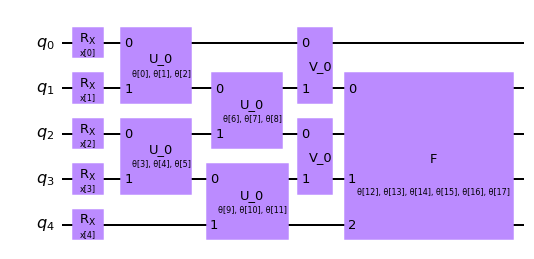

In [4]:
# Measure |0> state in qubit 3
operator = SingleProbability(qubits,3)

all_combination_data = generate_data_all_combi(qubits)
X,Y = generate_train_data(all_combination_data,train_set_size)

encode = LayeredFeatureMap.from_string("Rx(x)",num_qubits=qubits,num_features=qubits)
qcnn_pqc = encode + qcnn_train
qcnn_pqc.draw()

In [5]:
np.random.seed(13)
param_ini = np.random.rand(qcnn_pqc.num_parameters)
param_op_ini = np.random.rand(operator.num_parameters)
reg = QNNClassifier(qcnn_pqc,
                   operator,
                   Executor(Estimator()),
                   SquaredLoss,
                   Adam({"maxiter":150}),
                   param_ini,
                   param_op_ini,
                   opt_param_op=False,
                   batch_size=5,
                   epochs=50,
                   shuffle=True,
                   )

In [6]:
print("Test with",qubits,"qubits and",train_set_size,"train sets.")
print("Train data:")
print((X,Y))

Test with 5 qubits and 20 train sets.
Train data:
(array([[0, 1, 0, 0, 0],
       [1, 0, 0, 1, 0],
       [1, 1, 0, 1, 1],
       [1, 1, 0, 0, 1],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1],
       [0, 1, 1, 1, 1],
       [0, 1, 1, 1, 0],
       [1, 0, 1, 1, 1],
       [1, 0, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 0, 1, 1, 0],
       [1, 1, 1, 0, 1],
       [1, 0, 1, 0, 1],
       [0, 0, 0, 0, 0],
       [1, 0, 1, 1, 0],
       [0, 1, 1, 0, 1],
       [1, 1, 1, 1, 0]]), array([0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1],
      dtype=int64))


In [7]:
reg.fit(X, Y)

Epoch     1/   50:	average_loss = 0.32264
Epoch     2/   50:	average_loss = 0.25808
Epoch     3/   50:	average_loss = 0.23455
Epoch     4/   50:	average_loss = 0.22061
Epoch     5/   50:	average_loss = 0.22004
Epoch     6/   50:	average_loss = 0.21150
Epoch     7/   50:	average_loss = 0.20817
Epoch     8/   50:	average_loss = 0.20367
Epoch     9/   50:	average_loss = 0.20150
Epoch    10/   50:	average_loss = 0.20130
Epoch    11/   50:	average_loss = 0.19650
Epoch    12/   50:	average_loss = 0.19360
Epoch    13/   50:	average_loss = 0.19256
Epoch    14/   50:	average_loss = 0.18979
Epoch    15/   50:	average_loss = 0.18423
Epoch    16/   50:	average_loss = 0.17991
Epoch    17/   50:	average_loss = 0.17547
Epoch    18/   50:	average_loss = 0.17098
Epoch    19/   50:	average_loss = 0.16481
Epoch    20/   50:	average_loss = 0.15921
Epoch    21/   50:	average_loss = 0.15630
Epoch    22/   50:	average_loss = 0.15371
Epoch    23/   50:	average_loss = 0.14995
Epoch    24/   50:	average_loss = 

In [8]:

print("Test with",qubits,"qubits and",train_set_size,"train sets.")
print("Train data:")
print((X,Y))
X_test = all_combination_data[0]
Y_test = all_combination_data[1]
print("Test data:")
print(X_test)
print("predict",reg.predict(X_test))
print("ref",Y_test)
print("Score:",reg.score(X_test,Y_test))

Test with 5 qubits and 20 train sets.
Train data:
(array([[0, 1, 0, 0, 0],
       [1, 0, 0, 1, 0],
       [1, 1, 0, 1, 1],
       [1, 1, 0, 0, 1],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1],
       [0, 1, 1, 1, 1],
       [0, 1, 1, 1, 0],
       [1, 0, 1, 1, 1],
       [1, 0, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [0, 0, 1, 1, 0],
       [1, 1, 1, 0, 1],
       [1, 0, 1, 0, 1],
       [0, 0, 0, 0, 0],
       [1, 0, 1, 1, 0],
       [0, 1, 1, 0, 1],
       [1, 1, 1, 1, 0]]), array([0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1],
      dtype=int64))
Test data:
[[0 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 1 1]
 [0 0 1 0 0]
 [0 0 1 0 1]
 [0 0 1 1 0]
 [0 0 1 1 1]
 [0 1 0 0 0]
 [0 1 0 0 1]
 [0 1 0 1 0]
 [0 1 0 1 1]
 [0 1 1 0 0]
 [0 1 1 0 1]
 [0 1 1 1 0]
 [0 1 1 1 1]
 [1 0 0 0 0]
 [1 0 0 0 1]
 [1 0 0 1 0]
 [1 0 0 1 1]
 [1 0 1 0 0]
 [1 0 1 0 1]
 [1 0 1 1 0]
 [1 0 1 1 1]
 [1 1 0 0 0]
 [1 1 0 0 1]
 [1 1 0 1 0]
 [1 1 0 1 1]
 [1 